## BERT Hate Classifier on data with sentiment

In [1]:
import pandas as pd

In [3]:
#open BERT processed Sentiment data
BertSentData= pd.read_csv('DataSentiment3class.csv')
BertSentData= BertSentData.drop(columns='Unnamed: 0', axis=1)
# replace '' with ''
#BertSentData['Sentiment'].replace('LABEL_0', 'Negative', inplace=True)
#BertSentData['Sentiment'].replace('LABEL_1', 'Neutral', inplace=True)
#BertSentData['Sentiment'].replace('LABEL_2', 'Positive', inplace=True)

BertSentData.head()

,class,tweet,Sentiment,Score
0,2,woman shouldnt complain cleaning house man alw...,Negative,0.566340
1,1,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608
2,1,dawg ever fuck bitch start cry confused shit,Negative,0.974858
3,1,look like tranny,Negative,0.673002
4,1,shit hear might true might faker bitch told ya,Negative,0.695477


In [2]:
# setting value of N as the amount of hate labelled tweets to balance data
N = 1600
 
# using groupby to group acc. to
# column 'Variable'
Balanceddf = BertSentData.groupby('class').head(N).reset_index(drop=True)
Balanceddf['class'].value_counts()

NameError: name 'BertSentData' is not defined

In [4]:
Balanceddf.to_csv('BalancedProcessedBERTSentimentData.csv')

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset

# Combine tweet text with sentiment text
Balanceddf['combined_text'] = Balanceddf.apply(lambda row: f"{row['tweet']} [SEP] {row['Sentiment']}", axis=1)

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    Balanceddf['combined_text'], Balanceddf['class'], test_size=0.2, random_state=42
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the combined text
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Create a custom dataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
test_dataset = TweetDataset(test_encodings, test_labels.tolist())


C:\Users\Shaun\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
C:\Users\Shaun\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.195200
20,1.169400
30,1.168300
40,1.102300
50,1.141400
60,1.106700
70,1.085300
80,1.055600
90,1.030600
100,0.971800


TrainOutput(global_step=720, training_loss=0.5849439435535007, metrics={'train_runtime': 4046.1075, 'train_samples_per_second': 2.847, 'train_steps_per_second': 0.178, 'total_flos': 278242439247360.0, 'train_loss': 0.5849439435535007, 'epoch': 3.0})

In [7]:
# Save the trained model and tokenizer
model_save_path = './bert-hate-offensive-model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Evaluate the model
outputs = trainer.predict(test_dataset)
predictions = torch.argmax(torch.tensor(outputs.predictions), dim=1)

# Define your labels and target names
labels = [0, 1, 2]  #0: Hate, 1: Offensive, 2: Neither
target_names = ['Hate', 'Offensive', 'Neither']

# Print evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")
print(classification_report(test_labels, predictions, labels=labels, target_names=target_names))


Accuracy: 0.8385416666666666
              precision    recall  f1-score   support

        Hate       0.76      0.82      0.79       314
   Offensive       0.84      0.78      0.81       321
     Neither       0.92      0.91      0.91       325

    accuracy                           0.84       960
   macro avg       0.84      0.84      0.84       960
weighted avg       0.84      0.84      0.84       960



Accuracy: 0.8385416666666666
              precision    recall  f1-score   support

        Hate       0.76      0.82      0.79       314
   Offensive       0.84      0.78      0.81       321
     Neither       0.92      0.91      0.91       325

    accuracy                           0.84       960
   macro avg       0.84      0.84      0.84       960
weighted avg       0.84      0.84      0.84       960



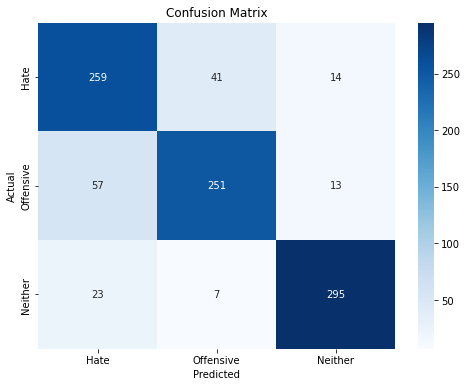

In [8]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Define your labels and target names
target_names = ['Hate', 'Offensive', 'Neither']

# Print the classification report for additional insights
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")
print(classification_report(test_labels, predictions, target_names=target_names))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## BERT without sentiment

In [9]:
BBertSentData= pd.read_csv('BalancedProcessedBERTSentimentData.csv')
BBertSentData

,Unnamed: 0,class,tweet,Sentiment,Score
0,0,2,woman shouldnt complain cleaning house man alw...,Negative,0.566340
1,1,1,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608
2,2,1,dawg ever fuck bitch start cry confused shit,Negative,0.974858
3,3,1,look like tranny,Negative,0.673002
4,4,1,shit hear might true might faker bitch told ya,Negative,0.695477
...,...,...,...,...,...
4795,4795,0,put pant whore dont let pussy hang,Negative,0.823633
4796,4796,0,kill,Neutral,0.483679
4797,4797,0,aint way gon na catch stan aint faggot + curb ...,Negative,0.728758
4798,4798,0,stay mad faggot hang,Negative,0.932202


In [10]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset

# If the elements are not strings, convert them to strings
BBertSentData['tweet'] = BBertSentData['tweet'].astype(str)

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    BBertSentData['tweet'], BBertSentData['class'], test_size=0.2, random_state=42
)


# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the combined text
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Create a custom dataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
test_dataset = TweetDataset(test_encodings, test_labels.tolist())


C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.115000
20,1.114300
30,1.104800
40,1.079400
50,1.102000
60,1.055600
70,1.055800
80,1.033200
90,1.035300
100,0.970500


TrainOutput(global_step=720, training_loss=0.573052113254865, metrics={'train_runtime': 3895.1351, 'train_samples_per_second': 2.958, 'train_steps_per_second': 0.185, 'total_flos': 266402335449600.0, 'train_loss': 0.573052113254865, 'epoch': 3.0})

In [12]:
# Save the trained model and tokenizer
model_save_path = './bert-hate-offensive-model(NoSentiment)'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Evaluate the model
outputs = trainer.predict(test_dataset)
predictions = torch.argmax(torch.tensor(outputs.predictions), dim=1)

# Define your labels and target names
labels = [0, 1, 2]  # Assuming 0: Hate, 1: Offensive, 2: Neither
target_names = ['Hate', 'Offensive', 'Neither']

# Print evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")
print(classification_report(test_labels, predictions, labels=labels, target_names=target_names))

Accuracy: 0.8458333333333333
              precision    recall  f1-score   support

        Hate       0.77      0.83      0.80       314
   Offensive       0.85      0.79      0.81       321
     Neither       0.92      0.92      0.92       325

    accuracy                           0.85       960
   macro avg       0.85      0.85      0.85       960
weighted avg       0.85      0.85      0.85       960



Accuracy: 0.8458333333333333
              precision    recall  f1-score   support

        Hate       0.77      0.83      0.80       314
   Offensive       0.85      0.79      0.81       321
     Neither       0.92      0.92      0.92       325

    accuracy                           0.85       960
   macro avg       0.85      0.85      0.85       960
weighted avg       0.85      0.85      0.85       960



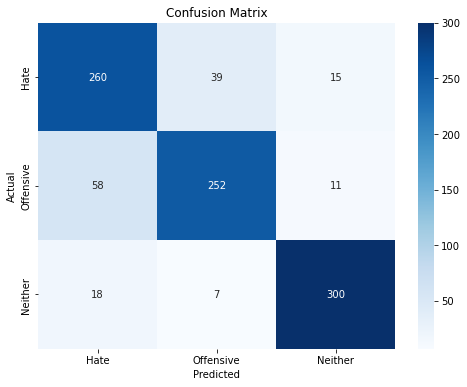

In [13]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm1 = confusion_matrix(test_labels, predictions)

# Define your labels and target names
target_names = ['Hate', 'Offensive', 'Neither']

# Print the classification report for additional insights
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")
print(classification_report(test_labels, predictions, target_names=target_names))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Alter to save

In [5]:
BBertSentData = pd.read_csv('BalancedProcessedBERTSentimentData.csv')

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset

# If the elements are not strings, convert them to strings
BBertSentData['tweet'] = BBertSentData['tweet'].astype(str)

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    BBertSentData['tweet'], BBertSentData['class'], test_size=0.2, random_state=42
)


# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the combined text
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Create a custom dataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
test_dataset = TweetDataset(test_encodings, test_labels.tolist())


# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.103800
20,1.091400
30,1.105200
40,1.096000
50,1.096000
60,1.083400
70,1.066600
80,1.055400
90,1.030000
100,1.011600


NameError: name 'os' is not defined

In [7]:
# Evaluate the model on the test dataset
outputs = trainer.predict(test_dataset)

# Convert raw predictions to class labels (argmax)
predictions = torch.argmax(torch.tensor(outputs.predictions), dim=1)

# Define labels and target names
labels = [0, 1, 2]  # Assuming 0: Hate, 1: Offensive, 2: Neither
target_names = ['Hate', 'Offensive', 'Neither']

# Import metrics from sklearn for classification report and accuracy
from sklearn.metrics import classification_report, accuracy_score

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")
print(classification_report(test_labels, predictions, labels=labels, target_names=target_names))


Accuracy: 0.8385416666666666
              precision    recall  f1-score   support

        Hate       0.80      0.76      0.78       314
   Offensive       0.80      0.82      0.81       321
     Neither       0.91      0.93      0.92       325

    accuracy                           0.84       960
   macro avg       0.84      0.84      0.84       960
weighted avg       0.84      0.84      0.84       960



In [8]:
import os
# Define the model save path and make sure the directory exists
model_save_path = './bert-hate-offensive-model(NoSentiment)'

# Check if the directory exists, if not, create it
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Save the trained model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./bert-hate-offensive-model(NoSentiment)\\tokenizer_config.json',
 './bert-hate-offensive-model(NoSentiment)\\special_tokens_map.json',
 './bert-hate-offensive-model(NoSentiment)\\vocab.txt',
 './bert-hate-offensive-model(NoSentiment)\\added_tokens.json')

## BERT pretrainned Twitter ctoraman/hate-speech-bert

In [24]:
Balanceddf = pd.read_csv('BalancedProcessedBERTSentimentData.csv')
Balanceddf

,Unnamed: 0,class,tweet,Sentiment,Score
0,0,2,woman shouldnt complain cleaning house man alw...,Negative,0.566340
1,1,1,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608
2,2,1,dawg ever fuck bitch start cry confused shit,Negative,0.974858
3,3,1,look like tranny,Negative,0.673002
4,4,1,shit hear might true might faker bitch told ya,Negative,0.695477
...,...,...,...,...,...
4795,4795,0,put pant whore dont let pussy hang,Negative,0.823633
4796,4796,0,kill,Neutral,0.483679
4797,4797,0,aint way gon na catch stan aint faggot + curb ...,Negative,0.728758
4798,4798,0,stay mad faggot hang,Negative,0.932202


In [25]:
# Create a mapping dictionary to align the dataset labels with the pre-trained model's labels
remap_labels = {0: 2, 1: 1, 2: 0}

# Apply the mapping to the 'class' column
Balanceddf['class'] = Balanceddf['class'].map(remap_labels)
Balanceddf

,Unnamed: 0,class,tweet,Sentiment,Score
0,0,0,woman shouldnt complain cleaning house man alw...,Negative,0.566340
1,1,1,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608
2,2,1,dawg ever fuck bitch start cry confused shit,Negative,0.974858
3,3,1,look like tranny,Negative,0.673002
4,4,1,shit hear might true might faker bitch told ya,Negative,0.695477
...,...,...,...,...,...
4795,4795,2,put pant whore dont let pussy hang,Negative,0.823633
4796,4796,2,kill,Neutral,0.483679
4797,4797,2,aint way gon na catch stan aint faggot + curb ...,Negative,0.728758
4798,4798,2,stay mad faggot hang,Negative,0.932202


In [27]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Convert the labels to Long tensor
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [30]:
# If the elements are not strings, convert them to strings
Balanceddf['tweet'] = Balanceddf['tweet'].astype(str)
Balanceddf

,Unnamed: 0,class,tweet,Sentiment,Score
0,0,0,woman shouldnt complain cleaning house man alw...,Negative,0.566340
1,1,1,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608
2,2,1,dawg ever fuck bitch start cry confused shit,Negative,0.974858
3,3,1,look like tranny,Negative,0.673002
4,4,1,shit hear might true might faker bitch told ya,Negative,0.695477
...,...,...,...,...,...
4795,4795,2,put pant whore dont let pussy hang,Negative,0.823633
4796,4796,2,kill,Neutral,0.483679
4797,4797,2,aint way gon na catch stan aint faggot + curb ...,Negative,0.728758
4798,4798,2,stay mad faggot hang,Negative,0.932202


In [31]:

train_texts, test_texts, train_labels, test_labels = train_test_split(
    Balanceddf['tweet'], Balanceddf['class'], test_size=0.2, random_state=42
)

#tokenization and training
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Create dataset objects
train_dataset = TweetDataset(train_encodings, train_labels.tolist())
test_dataset = TweetDataset(test_encodings, test_labels.tolist())

# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('ctoraman/hate-speech-bert', num_labels=3)

# Set up training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


Step,Training Loss
10,1.663400
20,1.643200
30,1.345600
40,1.216200
50,1.065200
60,0.964600
70,0.824700
80,0.822100
90,0.677200
100,0.667000


TrainOutput(global_step=720, training_loss=0.5173179752296871, metrics={'train_runtime': 1204.2346, 'train_samples_per_second': 9.566, 'train_steps_per_second': 0.598, 'total_flos': 266402335449600.0, 'train_loss': 0.5173179752296871, 'epoch': 3.0})

In [23]:
Balanceddf

,Unnamed: 0,class,tweet,Sentiment,Score,Classification,Classification_Label
0,0,NaN,woman shouldnt complain cleaning house man alw...,Negative,0.566340,0,Neither
1,1,NaN,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608,0,Neither
2,2,NaN,dawg ever fuck bitch start cry confused shit,Negative,0.974858,1,Offensive
3,3,NaN,look like tranny,Negative,0.673002,0,Neither
4,4,NaN,shit hear might true might faker bitch told ya,Negative,0.695477,1,Offensive
...,...,...,...,...,...,...,...
4795,4795,NaN,put pant whore dont let pussy hang,Negative,0.823633,1,Offensive
4796,4796,NaN,kill,Neutral,0.483679,2,Hate
4797,4797,NaN,aint way gon na catch stan aint faggot + curb ...,Negative,0.728758,1,Offensive
4798,4798,NaN,stay mad faggot hang,Negative,0.932202,1,Offensive


In [32]:
# Evaluate the model on the test dataset
outputs = trainer.predict(test_dataset)

# Convert raw predictions to class labels (argmax)
predictions = torch.argmax(torch.tensor(outputs.predictions), dim=1)

# Define labels and target names
labels = [2, 1, 0]  
target_names = ['Hate', 'Offensive', 'Neither']

# Import metrics from sklearn for classification report and accuracy
from sklearn.metrics import classification_report, accuracy_score

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")
print(classification_report(test_labels, predictions, labels=labels, target_names=target_names))

Accuracy: 0.8385416666666666
              precision    recall  f1-score   support

        Hate       0.79      0.78      0.79       314
   Offensive       0.80      0.82      0.81       321
     Neither       0.93      0.91      0.92       325

    accuracy                           0.84       960
   macro avg       0.84      0.84      0.84       960
weighted avg       0.84      0.84      0.84       960



In [33]:
# Save the trained model and tokenizer
model_save_path = './finetuned-bert-hate-offensive-model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./finetuned-bert-hate-offensive-model\\tokenizer_config.json',
 './finetuned-bert-hate-offensive-model\\special_tokens_map.json',
 './finetuned-bert-hate-offensive-model\\vocab.txt',
 './finetuned-bert-hate-offensive-model\\added_tokens.json')

In [4]:
#call to test accuracy against labeled 
from transformers import BertForSequenceClassification, BertTokenizer

# Load the trained model
model = BertForSequenceClassification.from_pretrained('ctoraman/hate-speech-bert')

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('ctoraman/hate-speech-bert')

C:\Users\Shaun\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
import torch
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer

# Function to classify a single tweet
def classify_tweet(tweet):
    # Tokenize the tweet and convert to tensor
    inputs = tokenizer(str(tweet), return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Get model output (logits)
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(**inputs)
    
    # Get predicted class (e.g., 0, 1, 2 for 'Hate', 'Offensive', 'Neither')
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    
    return predicted_class


In [12]:
# Apply the classify_tweet function to each row of the 'Tweet' column and create a new column 'Classification'
Balanceddf['Classification'] = Balanceddf['tweet'].apply(classify_tweet)

# Map class IDs to labels (assuming 0: 'Hate', 1: 'Offensive', 2: 'Neither')
class_mapping = {0: 'Neither', 1: 'Offensive', 2: 'Hate'}
Balanceddf['Classification_Label'] = Balanceddf['Classification'].map(class_mapping)

# Print the DataFrame with new columns
Balanceddf.head()

,Unnamed: 0,class,tweet,Sentiment,Score,Classification,Classification_Label
0,0,2,woman shouldnt complain cleaning house man alw...,Negative,0.566340,0,Neither
1,1,1,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608,0,Neither
2,2,1,dawg ever fuck bitch start cry confused shit,Negative,0.974858,1,Offensive
3,3,1,look like tranny,Negative,0.673002,0,Neither
4,4,1,shit hear might true might faker bitch told ya,Negative,0.695477,1,Offensive


In [14]:
Balanceddf['class'].replace(2, 'Neither', inplace=True)
Balanceddf['class'].replace(1, 'Offensive', inplace=True)
Balanceddf['class'].replace(0, 'Hate', inplace=True)
Balanceddf

,Unnamed: 0,class,tweet,Sentiment,Score,Classification,Classification_Label
0,0,Neither,woman shouldnt complain cleaning house man alw...,Negative,0.566340,0,Neither
1,1,Offensive,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608,0,Neither
2,2,Offensive,dawg ever fuck bitch start cry confused shit,Negative,0.974858,1,Offensive
3,3,Offensive,look like tranny,Negative,0.673002,0,Neither
4,4,Offensive,shit hear might true might faker bitch told ya,Negative,0.695477,1,Offensive
...,...,...,...,...,...,...,...
4795,4795,Hate,put pant whore dont let pussy hang,Negative,0.823633,1,Offensive
4796,4796,Hate,kill,Neutral,0.483679,2,Hate
4797,4797,Hate,aint way gon na catch stan aint faggot + curb ...,Negative,0.728758,1,Offensive
4798,4798,Hate,stay mad faggot hang,Negative,0.932202,1,Offensive


C:\Users\Shaun\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Accuracy: 0.5660416666666667
              precision    recall  f1-score   support

        Hate       0.83      0.04      0.07      1600
   Offensive       0.64      0.88      0.74      1600
     Neither       0.49      0.78      0.61      1600

    accuracy                           0.57      4800
   macro avg       0.66      0.57      0.47      4800
weighted avg       0.66      0.57      0.47      4800



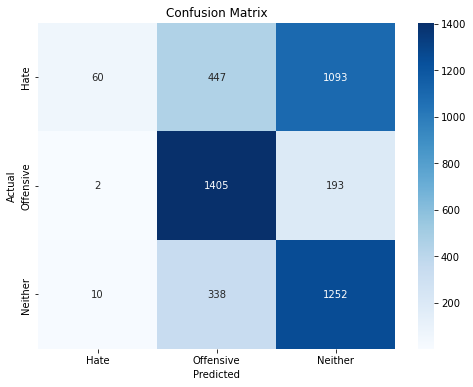

In [17]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming Balanceddf['class'] contains the actual labels and Balanceddf['Classification_Label'] contains predicted labels
actual_labels = Balanceddf['class']
predicted_labels = Balanceddf['Classification_Label']

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Define your target names (adjust these based on your class labels)
target_names = ['Hate', 'Offensive', 'Neither']

# Print the classification report and accuracy score
print(f"Accuracy: {accuracy_score(actual_labels, predicted_labels)}")
print(classification_report(actual_labels, predicted_labels, target_names=target_names))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
